# Homework 3 Problem 2

In this homework, you will implement LSTM models to predict the number of passengers at Seoul Station, Gangnam Station, and Yeouido Station. We'll provide you with basic skeleton codes with LSTM model. However, provided codes can be improved with some simple modifications. The purpose of this task is to implement code that solves the regression problem of estimating the number of passengers through LSTM.

## Upgrade Kernel

In [62]:
!pip install --upgrade ipython
!pip install --upgrade ipykernel

Requirement already up-to-date: ipython in /usr/local/lib/python3.6/dist-packages (7.14.0)
Requirement already up-to-date: ipykernel in /usr/local/lib/python3.6/dist-packages (5.3.0)


## Google Drive Mount (If you are not using CoLab, you can skip this process)

First, you need to access train.csv and test.csv from Google Drive to use the provided these files.

In [63]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Train and Test Dataset

In [0]:
import numpy as np
import pandas as pd
import csv
import copy
import datetime
import matplotlib.pyplot as plt

In [0]:
train_data = pd.read_csv('/content/gdrive/My Drive/train.csv')

In [66]:
train_data.head()

,date,station name,05 ~ 06,06 ~ 07,07 ~ 08,08 ~ 09,09 ~ 10,10 ~ 11,11 ~ 12,12 ~ 13,13 ~ 14,14 ~ 15,15 ~ 16,16 ~ 17,17 ~ 18,18 ~ 19,19 ~ 20,20 ~ 21,21 ~ 22,22 ~ 23,23 ~ 24,00 ~ 01
0,2018.1.1,Seoul Station,373,318,365,785,1047,1576,2510,3233,3145,2443,2980,3476,3891,3227,2945,2382,3070,1750,781,96
1,2018.1.2,Seoul Station,390,546,1936,2840,1767,1960,2935,3079,3175,2527,3239,3872,4943,9210,5214,3124,3321,1901,932,130
2,2018.1.3,Seoul Station,373,435,1443,2595,1712,2055,2402,2839,2839,2431,3133,3313,5109,9311,4799,2998,3117,1852,938,146
3,2018.1.4,Seoul Station,453,470,1379,2625,1716,1857,2645,2846,2980,2568,3267,3472,4737,9037,4847,3196,3422,2130,1110,170
4,2018.1.5,Seoul Station,419,506,1407,2504,1839,1930,2564,2946,3171,2636,3931,4381,5951,10146,5874,3527,3825,2740,1323,241


The data consists of date, station name, and number of passengers per hour.

We will implement a model that predicts the number of passengers after an hour with the current number of passengers as input. For example, when we know that the number of passengers from 05 ~ 06 in 2018.1.1 Seoul Station is 373, we want a model to predict the number of passengers (318) in 06 ~ 07. (It is assumed that the number of passengers before 05 ~ 06 is 0.)

## Data Preprocessing

Import basic modules (If you need other modules, you can import additional modules.)

In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

## Step 1) Base Encoding Version (4pt)

We need to encode the data to use train and test data as input to the LSTM model.
We'll do a very simple encoding first.


Dataset Encoding

As for the data we need to process, 20 data from 05:00 to 00:00 must be processed as one sequential data. Reflecting this, we construct the train dataset.

In [0]:
station_one_hot_dict = {
    "Seoul Station": [1, 0, 0],
    "Gangnam": [0, 1, 0],
    "Yeouido": [0, 0, 1]
}

In [0]:
time_lst = ['05 ~ 06', '06 ~ 07', '07 ~ 08', '08 ~ 09', '09 ~ 10', '10 ~ 11', '11 ~ 12', 
            '12 ~ 13', '13 ~ 14', '14 ~ 15', '15 ~ 16', '16 ~ 17', '17 ~ 18', '18 ~ 19', 
            '19 ~ 20', '20 ~ 21', '21 ~ 22', '22 ~ 23', '23 ~ 24', '00 ~ 01']

In [0]:
f = open('/content/gdrive/My Drive/train.csv', 'r')
rdr = csv.reader(f)

next(rdr)

train_inflow_seq_data_x = []
train_inflow_seq_data_y = []


for line in rdr:
    date = line[0]
    station_name = line[1]
    inflow_lst = line[2:]
    
    one_hot_station_name = station_one_hot_dict[station_name]
    
    train_data_x_lst = []
    train_data_y_lst = []
   
    for idx, (inflow, time) in enumerate(zip(inflow_lst, time_lst)):
        
        if idx == 0:
            previous_inflow = [0]
        else:
            previous_inflow = [int(inflow_lst[idx-1].strip().replace(",", ""))]
        
        data_x = one_hot_station_name + previous_inflow
        data_y = int(inflow.strip().replace(",", ""))

        train_data_x_lst.append(data_x)
        train_data_y_lst.append(data_y)
    
    train_inflow_seq_data_x.append(copy.deepcopy(train_data_x_lst))
    train_inflow_seq_data_y.append(copy.deepcopy(train_data_y_lst))

f.close()

In [0]:
f = open('/content/gdrive/My Drive/test.csv', 'r')
rdr = csv.reader(f)

next(rdr)

valid_inflow_seq_data_x = []
valid_inflow_seq_data_y = []


for line in rdr:
    date = line[0]
    station_name = line[1]
    inflow_lst = line[2:]
    
    one_hot_station_name = station_one_hot_dict[station_name]
    
    valid_data_x_lst = []
    valid_data_y_lst = []
   
    for idx, (inflow, time) in enumerate(zip(inflow_lst, time_lst)):
        
        if idx == 0:
            previous_inflow = [0]
        else:
            previous_inflow = [int(inflow_lst[idx-1].strip().replace(",", ""))]
        
        data_x = one_hot_station_name + previous_inflow
        data_y = int(inflow.strip().replace(",", ""))

        valid_data_x_lst.append(data_x)
        valid_data_y_lst.append(data_y)
    
    valid_inflow_seq_data_x.append(copy.deepcopy(valid_data_x_lst))
    valid_inflow_seq_data_y.append(copy.deepcopy(valid_data_y_lst))

f.close()

## Model

We will use the RMSE as loss function as shown below.

In [0]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))          # y and yhat tensors of same size (whatever size and whatever number oof dimension). Output is a single number (tensor)

In [73]:
BATCH_SIZE = 32
LEARNING_RATE = 0.005
TOTAL_EPOCH = 1000
GPU_DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

NUM_CLASS = 1
INPUT_SIZE = 4
HIDDEN_SIZE = 128
NUM_LAYERS = 2
SEQUENCE_LENGTH = 20
CRITERION = RMSELoss

print(GPU_DEVICE)

cuda:0


In [0]:
train_inflow_seq_data_x = np.array(train_inflow_seq_data_x, dtype=np.float32)
train_inflow_seq_data_y = np.array(train_inflow_seq_data_y, dtype=np.float32)

In [0]:
train_inflow_seq_data_x = torch.from_numpy(train_inflow_seq_data_x)
train_inflow_seq_data_y = torch.from_numpy(train_inflow_seq_data_y)

In [0]:
train_dataset = list(zip(train_inflow_seq_data_x, train_inflow_seq_data_y))
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [77]:
train_inflow_seq_data_x[0][1]

tensor([  1.,   0.,   0., 373.])

### LSTM Model 

[Problem 1] 
In the code below, put the appropriate code in '?' so that the code works fine. (1pt)

In [0]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.num_classes = NUM_CLASS
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.hidden_size = HIDDEN_SIZE
        self.sequence_length = SEQUENCE_LENGTH
        self.batch_size = BATCH_SIZE
        
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda(GPU_DEVICE)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda(GPU_DEVICE)
        # Propagate input through LSTM
        ula, (h_out, c_out) = self.lstm(x, (h_0, c_0))            # ula [batch size, seq len (20), hidden state]
        fc_input = torch.cat([ula[i] for i in range(ula.size(0))])      # fc input id the concatenation of the hidden layers [batch size*seq len (20), hidden state]
        out = self.fc(fc_input)
        return out.view(x.size(0), self.sequence_length)          # reshaping in [batch size, seq len (20)] (can probably simply do a .view(self.batch_size, self.sequence_length))

In [0]:
def fit(model, train_loader, criterion, learning_rate, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    loss_list = list()
    for epoch in range(num_epochs):
        loss_epoch = list()
        for i, data in enumerate(train_loader):
            input_x = data[0].type(torch.FloatTensor).cuda(GPU_DEVICE)      # input data rnn [batch size, seq len (20), input size]
            target = data[1].type(torch.FloatTensor).cuda(GPU_DEVICE)       # ground truth [batch size, seq len (20)]
            output = model(input_x)                                         # predictions [batch size, seq len (20)]
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch.append(loss.item())
        loss_list.append(sum(loss_epoch)/len(loss_epoch))
    return loss_list

In [80]:
net = LSTM().to(GPU_DEVICE)
print("Start training")
loss = fit(net, train_loader, CRITERION, LEARNING_RATE, TOTAL_EPOCH)
print("Done training")

Start training
Done training


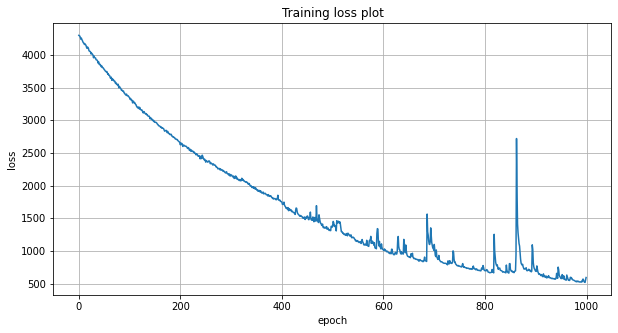

In [81]:
plt.figure(figsize=(10, 5))
plt.title("Training loss plot")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.plot(loss)
plt.show()

## Measure RMSE on test data and print RMSE. (Calculate RMSE in full-batch)

In [0]:
valid_inflow_seq_data_x = np.array(valid_inflow_seq_data_x, dtype=np.float32)
valid_inflow_seq_data_y = np.array(valid_inflow_seq_data_y, dtype=np.float32)

In [0]:
valid_inflow_seq_data_x = torch.from_numpy(valid_inflow_seq_data_x)
valid_inflow_seq_data_y = torch.from_numpy(valid_inflow_seq_data_y)

In [0]:
valid_dataset = list(zip(valid_inflow_seq_data_x, valid_inflow_seq_data_y))
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
def measureRMSE(model, valid_loader):
    output_list = list()
    target_list = list()
    model.eval()
    for i, data in enumerate(valid_loader):
        input_x = data[0].type(torch.FloatTensor).cuda(GPU_DEVICE)      # input data rnn [batch size, seq len (20), input size]
        target = data[1].type(torch.FloatTensor).cuda(GPU_DEVICE)       # ground truth [batch size, seq len (20)]
        output = model(input_x)                                         # predictions [batch size, seq len (20)]
        output_list.append(output)
        target_list.append(target)
    full_batch_output = torch.cat(output_list)
    full_batch_target = torch.cat(target_list)
    full_batch_loss = RMSELoss(full_batch_output, full_batch_target)
    return full_batch_loss


In [86]:
print("RMSE on the test dataset: ", measureRMSE(net, valid_loader).item())
# Write code to measure RMSE on test data and print RMSE (1.5 pt)

RMSE on the test dataset:  653.3561401367188


## Step2) LSTM model using encoding data with time information added (6pt)

We used a very simple encoding above as input. However, the input of the above model did not reflect the temporal factor. You have to make the input data by adding time information by referring to the code above.

The encoding you need to add is a one-hot vector for the day of the week(7) and times(20).
The days of the week are represented as 7-dimensional one-hot vectors from Monday to Sunday.
Time information is expressed as 20-dimensional one-hot vectors from '05 ~ 06' to '00 ~ 01'.
For example, if you represent the data corresponding to '06 ~ 07' of '2018.1.1' Seoul Station, it would be as follows.
[1, 0, 0, 373] + [1, 0, 0, 0, 0, 0, 0] + [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0]

## Data Preprocessing

You can use the code below if you want to use it, or you can implement it yourself.

In [0]:
time_lst = ['05 ~ 06', '06 ~ 07', '07 ~ 08', '08 ~ 09', '09 ~ 10', '10 ~ 11', '11 ~ 12', 
            '12 ~ 13', '13 ~ 14', '14 ~ 15', '15 ~ 16', '16 ~ 17', '17 ~ 18', '18 ~ 19', 
            '19 ~ 20', '20 ~ 21', '21 ~ 22', '22 ~ 23', '23 ~ 24', '00 ~ 01']

time_one_hot_dict = {}
total_time_cnt = len(time_lst)

for idx, time in enumerate(time_lst):
    temp_encoding_lst = [0] * total_time_cnt
    temp_encoding_lst[idx] = 1
    time_one_hot_dict[time] = temp_encoding_lst

In [0]:
day_lst = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

day_one_hot_dict = {}
total_day_cnt = len(day_lst)

for idx, time in enumerate(day_lst):
    temp_encoding_lst = [0] * total_day_cnt
    temp_encoding_lst[idx] = 1
    day_one_hot_dict[time] = temp_encoding_lst

In [0]:
def get_day_from_date(date):
    y, m, d = [int(x) for x in date.split(".")]
    d = datetime.date(y, m, d)
    return d.strftime("%a")

In [0]:
def read_dataset(path):
    f = open(path, 'r')
    rdr = csv.reader(f)
    next(rdr)
    inflow_seq_data_x = []
    inflow_seq_data_y = []
    for line in rdr:
        date = line[0]
        station_name = line[1]
        inflow_lst = line[2:]
        
        one_hot_station_name = station_one_hot_dict[station_name]
        one_hot_day = day_one_hot_dict[get_day_from_date(date)]

        data_x_lst = []
        data_y_lst = []
    
        for idx, (inflow, time) in enumerate(zip(inflow_lst, time_lst)):
            one_hot_time = time_one_hot_dict[time]
            if idx == 0:
                previous_inflow = [0]
            else:
                previous_inflow = [int(inflow_lst[idx-1].strip().replace(",", ""))]
            
            data_x = one_hot_station_name + previous_inflow + one_hot_day + one_hot_time
            data_y = int(inflow.strip().replace(",", ""))
            data_x_lst.append(data_x)
            data_y_lst.append(data_y)
        
        inflow_seq_data_x.append(copy.deepcopy(data_x_lst))
        inflow_seq_data_y.append(copy.deepcopy(data_y_lst))

    f.close()
    return inflow_seq_data_x, inflow_seq_data_y


In [91]:
train_inflow_seq_data_x, train_inflow_seq_data_y = read_dataset('/content/gdrive/My Drive/train.csv')
valid_inflow_seq_data_x, valid_inflow_seq_data_y = read_dataset('/content/gdrive/My Drive/test.csv')

train_inflow_seq_data_x = np.array(train_inflow_seq_data_x, dtype=np.float32)
train_inflow_seq_data_y = np.array(train_inflow_seq_data_y, dtype=np.float32)
train_inflow_seq_data_x = torch.from_numpy(train_inflow_seq_data_x)
train_inflow_seq_data_y = torch.from_numpy(train_inflow_seq_data_y)
train_dataset = list(zip(train_inflow_seq_data_x, train_inflow_seq_data_y))
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_inflow_seq_data_x = np.array(valid_inflow_seq_data_x, dtype=np.float32)
valid_inflow_seq_data_y = np.array(valid_inflow_seq_data_y, dtype=np.float32)
valid_inflow_seq_data_x = torch.from_numpy(valid_inflow_seq_data_x)
valid_inflow_seq_data_y = torch.from_numpy(valid_inflow_seq_data_y)
valid_dataset = list(zip(valid_inflow_seq_data_x, valid_inflow_seq_data_y))
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_inflow_seq_data_x[0][9]

tensor([1.0000e+00, 0.0000e+00, 0.0000e+00, 2.7550e+03, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00])

## LSTM Model

In [92]:
BATCH_SIZE = 32
LEARNING_RATE = 0.005
TOTAL_EPOCH = 1000
GPU_DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
NUM_CLASS = 1
INPUT_SIZE = 31
HIDDEN_SIZE = 128
NUM_LAYERS = 2
SEQUENCE_LENGTH = 20
CRITERION = RMSELoss

print(GPU_DEVICE)

cuda:0


In [0]:
class LSTM2(nn.Module):
    def __init__(self):
        super(LSTM2, self).__init__()
        
        self.num_classes = NUM_CLASS
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.hidden_size = HIDDEN_SIZE
        self.sequence_length = SEQUENCE_LENGTH
        self.batch_size = BATCH_SIZE
        
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda(GPU_DEVICE)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda(GPU_DEVICE)
        # Propagate input through LSTM
        ula, (h_out, c_out) = self.lstm(x, (h_0, c_0))      # ula [batch size, seq len (20), hidden state]
        fc_input = torch.cat([ula[i] for i in range(ula.size(0))])      # fc input id the concatenation of the hidden layers [batch size*seq len (20), hidden state]
        out = self.fc(fc_input)
        return out.view(x.size(0), self.sequence_length)    # reshaping in [batch size, seq len (20)] (can probably simply do a .view(self.batch_size, self.sequence_length))

In [97]:
time_net = LSTM2().to(GPU_DEVICE)
print("Start training")
loss = fit(time_net, train_loader, CRITERION, LEARNING_RATE, TOTAL_EPOCH)
print("Done training")

Start training
Done training


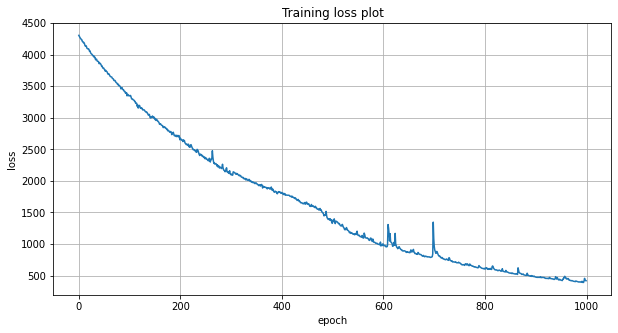

In [98]:
plt.figure(figsize=(10, 5))
plt.title("Training loss plot")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.plot(loss)
plt.show()

## Measure RMSE on test data and print RMSE. (Calculate RMSE in full-batch)

In [99]:
print("RMSE on the test dataset: ", measureRMSE(time_net, valid_loader).item())

RMSE on the test dataset:  483.64715576171875
